**Background**

Collaborative filtering is a method used in recommendation systems to suggest items to users based on the preferences and behaviors of other users. Basically assuming that if User A liked something and User B has similar taste to User A then User B will also like something User A liked. 

Matrix factorization models are used to discover latent features that explain the patterns in user-item interactions. We basically have a matrix R where rows (m) represent the users and the columns (n) represent the items. We then want to factorize R into two smaller matrices (P) an m * k where each row represents a user and the column represents a latent feature. For the item matrix Q n * k where each row represents an item and each column represents a latent feature of the item. Then the factorization attempts to approximate the matrix R from P * Q^T. The latent factors or hidden features are the things which get learned that explain the observed interaction between users and items. 

Once the latent features are learned the dot product is used to predict (rank) the rating of between the users and items. WHere the interaction between a user and an item can be estimated by measuring how well the latent feature vectors for that user and that item match or align with each other (the dot product). When there is a high dot product it means that the latent features for a user and an item align well, while a low dot product means that the vectors do not align.

However using the dot product does have some drawbacks. The dot product assumes that the user-item interactions are linearly dependent on the latent features. If two items are similar, the dot product assumes that the user’s preference for both items is simply the sum of their preferences for the individual latent features. The dot product assumes that user preferences can be captured by a single, linear combination of item attributes (represented by the item’s latent feature vector).


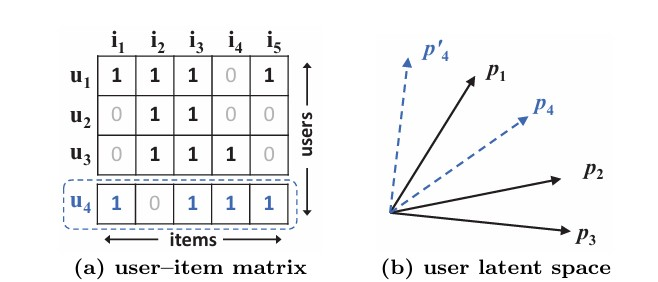

In [17]:
from IPython.display import Image
Image(filename='Images\\vector_latent_space.jpg')

Above shows MFs limitation with dot product.
 From data matrix (a), u4 is most similar to u1, fol
lowed by u3, and lastly u2. Which is the structure within the data meaning.
However when we put this into the latent space, by using the dot product it will incorrect model the true ranking.
As in the latent space (the arrows), placing p4 closest to p1 makes p4 closer to p2 than p3, which is incorrect.

**General model framework of neral collaborative filtering**

The `GMFModel` is an implementation of **Generalized Matrix Factorization (GMF)** within the **Neural Collaborative Filtering (NCF)** framework. **Matrix Factorization (MF)** is a classical technique in recommendation systems where user and item interactions are modeled by the **dot product** of their respective latent vectors. In GMF, the core operation is the **element-wise product** of the user and item embeddings, which generalizes the dot product used in MF. This interaction term is then combined with additional features such as **episodes**, **type**, and **genre**, and passed through a neural network for prediction.

The model defines **user** and **item embeddings** using PyTorch's `nn.Embedding`, where each user and item has a learned vector representation. These embeddings are multiplied element-wise to model the interaction between users and items. The resulting interaction vector is concatenated with other input features (episodes, type, genre) and fed through a fully connected layer followed by a **sigmoid activation** to predict a probability (e.g., whether a user will like an anime or not).

By using the **sigmoid function** in the output layer, GMF can be interpreted as a probabilistic model, suitable for tasks such as rating prediction or binary classification. If we were to use a **linear activation** and restrict the interaction term to a simple dot product, the model would recover the standard MF approach. GMF generalizes MF by allowing for **non-linear interactions** and by incorporating additional features, making it more expressive and flexible than traditional matrix factorization.


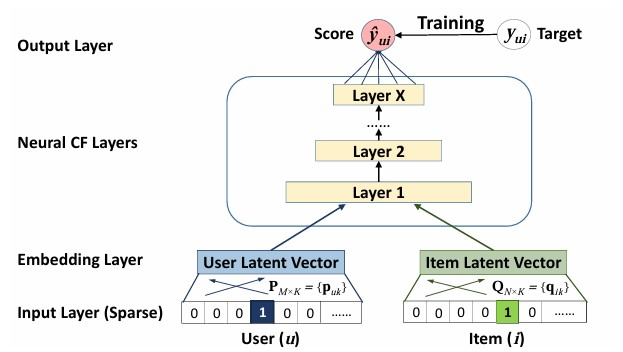

In [15]:
#Below is the general overview of how a model will look within this framework
from IPython.display import Image
Image(filename='Images\\NEF_framework.jpg')

In [ ]:
import torch
from torch import nn


class GMFModel(torch.nn.Module):
    def __init__(self, uid_count, animeid_count, genre_count, latent_dim_len):
        super(GMFModel, self).__init__()
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.uid_count = uid_count
        self.animeid_count = animeid_count
        self.genre_count = genre_count  
        self.latent_dim_len = latent_dim_len

        self.uid_embedding = nn.Embedding(num_embeddings=self.uid_count, embedding_dim=self.latent_dim_len)
        self.animeid_embedding = nn.Embedding(num_embeddings=self.animeid_count, embedding_dim=self.latent_dim_len)
        self.uid_embedding.to(device)
        self.animeid_embedding.to(device)

        self.dropout = nn.Dropout(0.3)

        input_dim = self.latent_dim_len + 2 + self.genre_count
        
        # Output layer
        self.output_layer = nn.Sequential(
            nn.Linear(in_features=input_dim, out_features=1),
            nn.Sigmoid())

        # Initialize weights
        self.apply(self.init_weights)

    def forward(self, uid_index, animeid_index, episodes, type, genre):
        # Get user and item embeddings
        uid_e = self.uid_embedding(uid_index)
        animeid_e = self.animeid_embedding(animeid_index)
    
        product = uid_e * animeid_e 
        product = self.dropout(product)

        episodes = episodes.unsqueeze(1)  
        type = type.unsqueeze(1)  
        genre = genre.squeeze(1)  

        # Concatenate all features into one vector
        model_input = torch.cat([product, episodes, type, genre], dim=-1)

        # Pass input through the output layer
        score = self.output_layer(model_input)
        return score.squeeze()


    def init_weights(self, m):
        if isinstance(m, nn.Linear):
            nn.init.xavier_normal_(m.weight)
            if m.bias is not None:
                nn.init.zeros_(m.bias)

        if isinstance(m, nn.Embedding):
            nn.init.normal_(m.weight, mean=0.0, std=0.01)


This code implements a **Multi-Layer Perceptron (MLP)** model for a recommendation system, drawing inspiration from the **Neural Collaborative Filtering (NCF)** framework. In this setup, user and item features are represented by embeddings, which are concatenated with additional features (e.g., episodes, type, and genre) to form a combined input vector. This vector is passed through a series of hidden layers with **ReLU** activations, which learn the interactions between the user and item latent features. This approach contrasts with simpler methods like **GMF**, which only use element-wise products of latent vectors.

The **MLP** model in the NCF framework emphasizes capturing **non-linear interactions** between user and item features, which is done by using a multi-layer architecture. The model employs a **tower structure**, where the layer size progressively decreases. Dropout layers are used for regularization to prevent overfitting.

One key difference is the **ReLU activation** in the output layer, which constrains the model's predictions to be non-negative. If your task involves predicting ratings (e.g., on a 1–5 scale), you may want to adjust this to a **linear activation** or a **sigmoid/tanh** function, depending on the range of values needed.


In [87]:
import torch
from torch import nn


class MLPModel(torch.nn.Module):
    def __init__(self, uid_count, animeid_count, genre_count, latent_dim_len, hidden):
        super(MLPModel, self).__init__()
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.uid_count = uid_count
        self.animeid_count = animeid_count
        self.genre_count = genre_count  # Number of one-hot encoded genres
        self.latent_dim_len = latent_dim_len
        self.hidden_layer = hidden

        # Embedding layers for user and anime
        self.uid_embedding = nn.Embedding(num_embeddings=self.uid_count, embedding_dim=self.latent_dim_len)
        self.animeid_embedding = nn.Embedding(num_embeddings=self.animeid_count, embedding_dim=self.latent_dim_len)
        self.uid_embedding.to(device)
        self.animeid_embedding.to(device)

        self.layers = nn.ModuleList()

        # Combine user, item, and non-embedding features
        input_dim = self.latent_dim_len * 2 + 2 + self.genre_count

        # Hidden layers with ReLU activation, from paper
        for dim in self.hidden_layer:
            self.layers.append(nn.Linear(in_features=input_dim, out_features=dim))
            self.layers.append(nn.ReLU())
            self.layers.append(nn.Dropout(0.3))
            input_dim = dim

        # Output layer with ReLU activation
        self.output_layer = nn.Sequential(
            nn.Linear(in_features=self.hidden_layer[-1], out_features=1),
            nn.ReLU())  

        self.apply(self.init_weights)

    def forward(self, uid_index, animeid_index, episodes, type, genre):
        uid_e = self.uid_embedding(uid_index)
        animeid_e = self.animeid_embedding(animeid_index)
        episodes = episodes.unsqueeze(1) 
        type = type.unsqueeze(1) 

        model_input = torch.cat([uid_e, animeid_e, episodes, type, genre], dim=-1)

        # Pass input through hidden layers
        for hidden_layer in self.layers:
            model_input = hidden_layer(model_input)

        # Compute final output score 
        score = self.output_layer(model_input)
        return score.squeeze()

    def init_weights(self, m):
        if isinstance(m, nn.Linear):
            nn.init.xavier_normal_(m.weight)
            if m.bias is not None:
                nn.init.zeros_(m.bias)

        if isinstance(m, nn.Embedding):
            nn.init.normal_(m.weight, mean=0.0, std=0.01)

In this implementation of the **Neural Matrix Factorization (NeuMF)** model, the goal is to combine two types of models—**Generalized Matrix Factorization (GMF)** and **Multi-Layer Perceptron (MLP)**—to capture both linear and non-linear interactions between users and items, providing a more powerful recommendation system. 

The **GMF** component of the model applies a linear kernel to model the latent feature interactions between users and items. Specifically, it computes the dot product of user and item embeddings to capture linear relationships. In this part of the model, each user and item is represented by a latent vector, and their interaction is modeled as the element-wise multiplication of these vectors. This approach is simple but effective for modeling linear patterns in the data.

On the other hand, the **MLP** component of the NeuMF model uses a deep neural network to learn non-linear interactions between the user and item embeddings. This part of the model is more flexible and capable of learning complex patterns that the GMF component might miss. The MLP uses multiple layers of fully connected neurons with activation functions (typically ReLU) and regularization (like dropout) to model non-linear relationships in the user-item interaction.

Rather than forcing the GMF and MLP to share the same embeddings, which could limit the model's ability to learn the best representations, the NeuMF model allows the GMF and MLP components to have separate embeddings. This flexibility helps the model learn more effective representations, especially in cases where the optimal latent dimension for the GMF and MLP components might differ. The outputs of these two models are then combined by concatenating their respective outputs and passing them through a final layer to produce the predicted interaction score. This fusion of the two models effectively leverages both the linear nature of GMF and the non-linear nature of MLP, giving the NeuMF model a powerful ability to capture complex user-item interactions.

To improve the training of the NeuMF model and overcome the challenge of local optima in non-convex optimization problems, the model is pre-trained using separate GMF and MLP models. These models are trained independently on the dataset first, using random initialization and an optimization method such as Adam. After these models converge, their learned parameters (embeddings and weights) are transferred into the NeuMF model. This pre-training strategy provides a better starting point for the NeuMF model, allowing it to converge more quickly and perform better during fine-tuning. In particular, the embeddings for the GMF and MLP components are initialized with the pre-trained values, and the final fusion layer's weights are adjusted to control the trade-off between the GMF and MLP outputs.

Once the pre-training is complete, the NeuMF model is trained using **stochastic gradient descent (SGD)**, as opposed to Adam, because the latter relies on momentum, which is not suitable when we are using pre-trained weights. SGD is more appropriate for fine-tuning the model after the initial embeddings have been loaded, as it allows for more stable updates without relying on momentum.

This approach of combining GMF and MLP in the NeuMF framework, along with the pre-training strategy, allows the model to benefit from both the simplicity and interpretability of GMF's linear interactions and the flexibility of MLP's non-linear learning. By fusing the strengths of both models and leveraging pre-trained embeddings, the NeuMF model can better capture complex relationships between users and items, leading to more accurate predictions in recommendation systems.

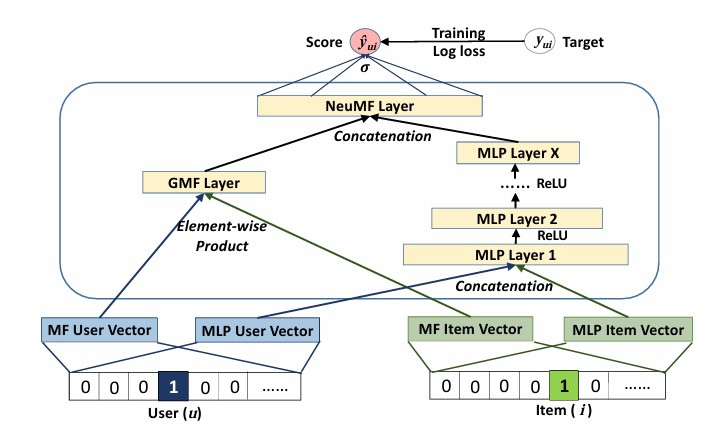

In [ ]:
#An image of the NEUF model
from IPython.display import Image
Image(filename='Images\\NEUF.jpg')


In [88]:
import torch
from torch import nn


class NeuMFModel(torch.nn.Module):
    def __init__(self, uid_count, animeid_count, genre_count, latent_dim_len, hidden):
        super(NeuMFModel, self).__init__()
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.uid_count = uid_count
        self.animeid_count = animeid_count
        self.genre_count = genre_count  # Number of one-hot encoded genres
        self.latent_dim_len = latent_dim_len
        self.hidden_layer = hidden

        # Embedding layers for user and anime
        self.uid_embedding_gmf = nn.Embedding(num_embeddings=self.uid_count, embedding_dim=self.latent_dim_len)
        self.animeid_embedding_gmf = nn.Embedding(num_embeddings=self.animeid_count, embedding_dim=self.latent_dim_len)
        self.uid_embedding_mlp = nn.Embedding(num_embeddings=self.uid_count, embedding_dim=self.latent_dim_len)
        self.animeid_embedding_mlp = nn.Embedding(num_embeddings=self.animeid_count, embedding_dim=self.latent_dim_len)

        # Define the layers of the MLP
        self.layers = nn.ModuleList()

        # Combine user, item, and non-embedding features
        input_dim = self.latent_dim_len * 2 + 2 + self.genre_count

        for dim in self.hidden_layer:
            self.layers.append(nn.Linear(in_features=input_dim, out_features=dim))
            self.layers.append(nn.ReLU())
            self.layers.append(nn.Dropout(0.3))
            input_dim = dim

        # Output layer
        self.output_layer = nn.Sequential(
            nn.Linear(in_features=self.hidden_layer[-1] + self.latent_dim_len, out_features=1),
            nn.Sigmoid()) 

        # Initialize weights
        self.apply(self.init_weights)

    def forward(self, uid_index, animeid_index, episodes, type, genre):
        # Get user and item embeddings
        uid_mlp = self.uid_embedding_mlp(uid_index)
        animeid_mlp = self.animeid_embedding_mlp(animeid_index)
        uid_gmf = self.uid_embedding_gmf(uid_index)
        animeid_gmf = self.animeid_embedding_gmf(animeid_index)
        

        episodes = episodes.unsqueeze(1)  # (batch_size, 1)
        type = type.unsqueeze(1)
        # Concatenate all features into one vector
        model_input = torch.cat([uid_mlp, animeid_mlp, episodes, type, genre], dim=-1)
        product = torch.mul(uid_gmf, animeid_gmf)

        # Pass input through hidden layers
        for hidden_layer in self.layers:
            model_input = hidden_layer(model_input)
            product = torch.nn.ReLU()(product)

        # Compute final output score (prediction)
        vector = torch.cat([model_input, product], dim=-1)
        score = self.output_layer(vector)
        return score.squeeze()

    def init_weights(self, m):
        if isinstance(m, nn.Linear):
            nn.init.xavier_normal_(m.weight)
            if m.bias is not None:
                nn.init.zeros_(m.bias)

        if isinstance(m, nn.Embedding):
            nn.init.normal_(m.weight, mean=0.0, std=0.01)

    def pretrain_loader(self):
        mlp_model = MLPModel(uid_count=uid_count,
                         animeid_count=animeid_count,
                         genre_count=genre_count,
                         latent_dim_len=latent_dim_len,
                         hidden=hidden_layers)

        gmf_model = GMFModel(uid_count=uid_count,
                         animeid_count=animeid_count,
                         genre_count=genre_count,
                         latent_dim_len=latent_dim_len)

        # Move models to GPU
        mlp_model.cuda()
        gmf_model.cuda()

        # Load the weights from pre-trained models
        mlp_model.load_state_dict(torch.load('models/mlp_model.pth'))
        gmf_model.load_state_dict(torch.load('models/gmf_model.pth'))

        # Load the embedding layers from the MLP and GMF models into NeuMF
        self.uid_embedding_mlp.weight.data = mlp_model.uid_embedding.weight.data
        self.animeid_embedding_mlp.weight.data = mlp_model.animeid_embedding.weight.data
        self.uid_embedding_gmf.weight.data = gmf_model.uid_embedding.weight.data
        self.animeid_embedding_gmf.weight.data = gmf_model.animeid_embedding.weight.data

        # Load the MLP hidden layers' weights into the NeuMF model
        for i in range(len(self.layers)):
            if isinstance(self.layers[i], nn.Linear):
                # Only load weights for Linear layers
                self.layers[i].weight.data = mlp_model.layers[i].weight.data
                self.layers[i].bias.data = mlp_model.layers[i].bias.data

This Python code defines the `AnimeData` class for preparing and processing anime and user rating data using the `scikit-learn`, `pandas`, and `torch` libraries. The `__init__` method initializes the class with the input datasets, encodes categorical data using `LabelEncoder` and `MultiLabelBinarizer`, and merges user ratings with anime information. The processed data includes one-hot encoded genres and numerical mappings for IDs, names, and types. The `process` method encodes the input features, while `__len__` and `__getitem__` provide data access and indexing. The `get_loaders` method splits the dataset into training and test sets, converts them into PyTorch tensors, and organizes them into `DataLoader` objects for batch processing during model training and evaluation. 

In [90]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, MultiLabelBinarizer
import pandas as pd
import torch
from torch.utils.data import DataLoader, TensorDataset

class AnimeData(object):
    def __init__(self, ratings, anime):
        self.ratings = ratings
        self.anime = anime
        encoder = LabelEncoder()

        # Remove data where user did not rate anime
        self.ratings = self.ratings.loc[self.ratings.iloc[:, 2] != -1]

        # Remove overall members and rating -> not needed
        self.anime.drop(['members', 'rating'], axis=1, inplace=True)

        # anime_id,name,genre,type,episodes,rating,members
        # user_id,anime_id,rating

        # Encode the IDs to an integer mapping for embedding
        self.ratings['user_id'] = self.ratings['user_id'].astype("category").cat.codes
        self.ratings['anime_id'] = self.ratings['anime_id'].astype("category").cat.codes
        self.anime['anime_id'] = self.anime['anime_id'].astype("category").cat.codes
        self.anime = self.anime[self.anime['episodes'] != 'Unknown']

        # Encode the name and type
        self.anime['name'] = encoder.fit_transform(self.anime['name'])
        self.name_map = dict(zip(encoder.classes_, encoder.transform(encoder.classes_)))
        
        self.anime['type'] = encoder.fit_transform(self.anime['type'])
        self.type_map = dict(zip(encoder.classes_, encoder.transform(encoder.classes_)))

        # One hot encode the genres
        self.anime['genre'] = self.anime['genre'].str.split(', ')
        bin = MultiLabelBinarizer()
        onehot = bin.fit_transform(self.anime['genre'])
        dfs = pd.DataFrame(onehot, columns=bin.classes_)
        self.anime.drop('genre', axis=1, inplace=True)
        self.anime.reset_index(drop=True, inplace=True)
        dfs.reset_index(drop=True, inplace=True)
        self.genre = dfs
        self.anime = pd.concat([self.anime, dfs], axis=1)

        # Merge user and anime data into single dataset
        self.data = self.ratings.merge(self.anime, on='anime_id', how='left')
        self.data['rating'] = self.data['rating'] / 10

        self.data['episodes'] = self.data['episodes'].astype('int64')

        self.features = self.data[['user_id', 'anime_id', 'type', 'episodes']+ list(self.genre.columns)]
        self.target = self.data['rating']

        self.genre_cols = self.features.columns[5:]

    def process(self, item):
        # Encode the type and name
        tid = self.type_map[item[2]]  # "TV" -> Encoded type using `type_map`
        #name = self.name_map[item[3]]  # Anime name -> Encoded name using `name_map`, unused
        
        # One-hot encode the genres
        genre_encoded = [1 if genre in item[5].split(", ") else 0 for genre in self.genre_cols]
        
        # Combine all the features into a single list
        dfn = [item[0],  # anime_id
               item[1],  # user_id
               tid,      # Encoded type
               item[4]]  # episodes
        dfn += genre_encoded  # Append the genre encoding
        
        # Return as a Pandas Series (1D array)
        cols = ['user_id', 'anime_id', 'type', 'episodes'] + list(self.genre.columns)
        return pd.Series(dfn, index=cols)

    def __len__(self):
        return len(self.features)

    def __getitem__(self, item):
        x = self.features[item]
        y = self.target[item]
        if self.transform:
            x = self.transform(x)
        return x, y

    def get_loaders(self):
        train, test = train_test_split(self.data, test_size=0.2)

        train_user_item = torch.tensor(train[self.features.columns].values, dtype=torch.long)
        train_labels = torch.tensor(train['rating'].values, dtype=torch.float32)

        test_user_item = torch.tensor(test[self.features.columns].values, dtype=torch.long)
        test_labels = torch.tensor(test['rating'].values, dtype=torch.float32)

        train_set = TensorDataset(train_user_item[:, 0], # user_id
                                  train_user_item[:, 1], # anime_id
                                  train_user_item[:, 2], # type
                                  train_user_item[:, 3], # episodes
                                  train_user_item[:, 4:], # genres
                                  train_labels)
        test_set = TensorDataset(test_user_item[:, 0], # user_id
                                  test_user_item[:, 1], # anime_id
                                  test_user_item[:, 2], # type
                                  test_user_item[:, 3], # episodes
                                  test_user_item[:, 4:], # genres
                                  test_labels)

        train = DataLoader(train_set, batch_size=128, shuffle=True)
        test = DataLoader(test_set, batch_size=128, shuffle=True)

        return train, test



The code implements a recommendation system for anime using collaborative filtering and neural network models in PyTorch, featuring three model architectures: MLP (Multilayer Perceptron), GMF (Generalized Matrix Factorization), and NeuMF (Neural Matrix Factorization). The system begins by loading and cleaning data from two CSV files (`anime.csv` for anime metadata and `rating.csv` for user ratings), removing missing values and irrelevant entries. This processed data is then used to train the models. The MLP model is a neural network that learns latent factors through hidden layers, the GMF model uses matrix factorization to focus on collaborative filtering, and the NeuMF model combines both MLP and GMF to leverage the strengths of both approaches. Each model is initialized with key parameters such as user and item counts and latent dimensions. The training process uses the Adam optimizer with MSE loss, running for multiple epochs. During training, evaluation metrics like MAE, RMSE, and R² are calculated to track performance on both training and test sets. Device handling ensures that if a GPU is available, it is used to speed up computations. 

The output shows that the MLP model demonstrates gradual improvement, but its test loss fluctuates slightly, indicating room for better generalization. Its evaluation metrics (MAE = 0.1104, RMSE = 0.1386, R² = 0.2205) suggest the model is still underperforming. The GMF model improves on the MLP, with better evaluation metrics (MAE = 0.0909, RMSE = 0.1201, R² = 0.4143), indicating it captures user-item interactions more effectively. The NeuMF model, a hybrid of MLP and GMF, outperforms both, with the best evaluation results (MAE = 0.0870, RMSE = 0.1151, R² = 0.4624), demonstrating the power of combining neural networks with matrix factorization. Insights from the results show that while the training loss decreases steadily, the fluctuating test loss suggests potential overfitting, pointing to the need for further regularization and tuning. The improvement in R² across models, especially with NeuMF, underscores the value of hybrid approaches in capturing complex user-item relationships. To optimize performance, hyperparameter tuning, regularization techniques like dropout, and using more advanced methods like cross-validation or embedding layers could further enhance the system. In conclusion, the code successfully trains and evaluates three recommendation models, with the NeuMF model performing the best, offering a promising foundation for further optimization and refinement.

In [94]:
import pandas as pd
#from mlp import MLPModel
#from gmf import GMFModel
from torch import nn
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
df1 = pd.read_csv('data/anime.csv')
df2 = pd.read_csv('data/rating.csv')
df2 = df2[:1000000]


df1.dropna(inplace=True)
df2.dropna(inplace=True)
df2 = df2.loc[df2.iloc[:, 2] != -1]

df1 = df1[df1['episodes'] != 'Unknown']

handler = AnimeData(df2, df1)

uid_count = len(handler.ratings['user_id'].unique())  # Number of unique users
animeid_count = len(handler.anime['anime_id'].unique())  # Number of unique anime
genre_count = 43  # Number of one-hot encoded genre categories
latent_dim_len = 50  # Latent dimension length for embeddings
hidden_layers = [128, 64, 32, 16]  # Example hidden layers for MLP

# Initialize the MLP model

mlp_model = MLPModel(uid_count=uid_count,
                 animeid_count=animeid_count,
                 genre_count=genre_count,
                 latent_dim_len=latent_dim_len,
                 hidden=hidden_layers)

gmf_model = GMFModel(uid_count=uid_count,
                 animeid_count=animeid_count,
                 genre_count=genre_count,
                 latent_dim_len=latent_dim_len)

neumf_model = NeuMFModel(uid_count=uid_count,
                 animeid_count=animeid_count,
                 genre_count=genre_count,
                 latent_dim_len=latent_dim_len,
                 hidden=hidden_layers)

gmf_model.to(device)
mlp_model.to(device)
neumf_model.to(device)
a, b = handler.get_loaders()

loss_function = nn.MSELoss()
gmfo = torch.optim.Adam(gmf_model.parameters(), lr=0.0001)
mlpo = torch.optim.Adam(mlp_model.parameters(), lr=0.0001)
nfmo = torch.optim.SGD(neumf_model.parameters(), lr=0.0001, momentum=0.9)



def run_and_eval(a, b, model, opt, lr=0.001, epochs=10):
    optimizer = opt
    loss_function = nn .MSELoss()
    model.train()
    
    for i in range(epochs):
        model.train()
        total_loss = 0
        for user, anime, type,episodes, genre, labels in a:
            user, anime = user.to(device), anime.to(device)
            episodes, type, genre = episodes.to(device), type.to(device), genre.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()
            pred = model(user, anime, episodes, type, genre)
            loss = loss_function(pred, labels)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        print(f"Epoch [{i + 1}/{10}], Loss: {total_loss / len(a)}")

        model.eval()  # Set the model to evaluation mode
        total_loss = 0
        total_samples = 0
        all_predictions = []
        all_labels = []

        with torch.no_grad():  # Disable gradient calculation
            for user, anime, type, episodes, genre, labels in b:
                user, anime = user.to(device), anime.to(device)
                episodes, type, genre = episodes.to(device), type.to(device), genre.to(device)
                labels = labels.to(device)

                # Get model predictions
                pred = model(user, anime, episodes, type, genre)

                # Calculate the loss (e.g., MSE loss)
                loss = loss_function(pred, labels)
                total_loss += loss.item() * len(labels)  # Accumulate loss
                total_samples += len(labels)  # Accumulate the number of samples

                # Store predictions and actual values
                all_predictions.extend(pred.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())

        # Calculate average loss
        avg_loss = total_loss / total_samples
        print(f"Test Loss [{i+1}/10]: {avg_loss}")

    # Additional Metrics
    from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

    mae = mean_absolute_error(all_labels, all_predictions)
    mse = mean_squared_error(all_labels, all_predictions)
    rmse = mse ** 0.5
    r2 = r2_score(all_labels, all_predictions)

    print(f"Test MAE: {mae:.4f}")
    print(f"Test RMSE: {rmse:.4f}")
    print(f"R² Score: {r2:.4f}")


run_and_eval(a, b, mlp_model, mlpo, lr=0.0001, epochs=10)
#torch.save(mlp_model.state_dict(), 'mlp_model.pth')
print()
run_and_eval(a, b, gmf_model, gmfo, lr=0.0001, epochs=10)
#torch.save(gmf_model.state_dict(), 'gmf_model.pth')

neumf_model.pretrain_loader()
run_and_eval(a, b, neumf_model, nfmo, lr=0.0001, epochs=10)
torch.save(neumf_model.state_dict(), 'neumf_model.pth')

Using device: cuda
Epoch [1/10], Loss: 3.6950174334295
Test Loss [1/10]: 0.157952371776796
Epoch [2/10], Loss: 0.11668900996973773
Test Loss [2/10]: 0.03814665263147855
Epoch [3/10], Loss: 0.040147326586463444
Test Loss [3/10]: 0.022276981720272128
Epoch [4/10], Loss: 0.022898902423949267
Test Loss [4/10]: 0.0206319713626718
Epoch [5/10], Loss: 0.019955833869365353
Test Loss [5/10]: 0.020516480288159767
Epoch [6/10], Loss: 0.018866505908579186
Test Loss [6/10]: 0.020635879038299828
Epoch [7/10], Loss: 0.01828422652079384
Test Loss [7/10]: 0.02011084193172132
Epoch [8/10], Loss: 0.017863553787622624
Test Loss [8/10]: 0.019992064000603074
Epoch [9/10], Loss: 0.0176579500614437
Test Loss [9/10]: 0.020253627192886033
Epoch [10/10], Loss: 0.017454158246397105
Test Loss [10/10]: 0.019198449493947483
Test MAE: 0.1104
Test RMSE: 0.1386
R² Score: 0.2205

Epoch [1/10], Loss: 0.04003728575764353
Test Loss [1/10]: 0.028299097051615502
Epoch [2/10], Loss: 0.025533486508182983
Test Loss [2/10]: 0.02

This code uses Matplotlib to plot the training and test losses over 10 epochs for three different models: MLP, GMF, and NeuMF. It initializes lists for the training and test losses of each model, then creates separate plots for each model, showing how losses change across epochs. Blue markers represent training loss while red markers indicate test loss. Each plot is labeled with the respective model name, and axes are labeled for clarity. These plots help visualize and compare the performance and convergence of the models, highlighting how well each one learns and generalizes over time. This detailed analysis aids in understanding the training progress and the effectiveness of each model in reducing loss.

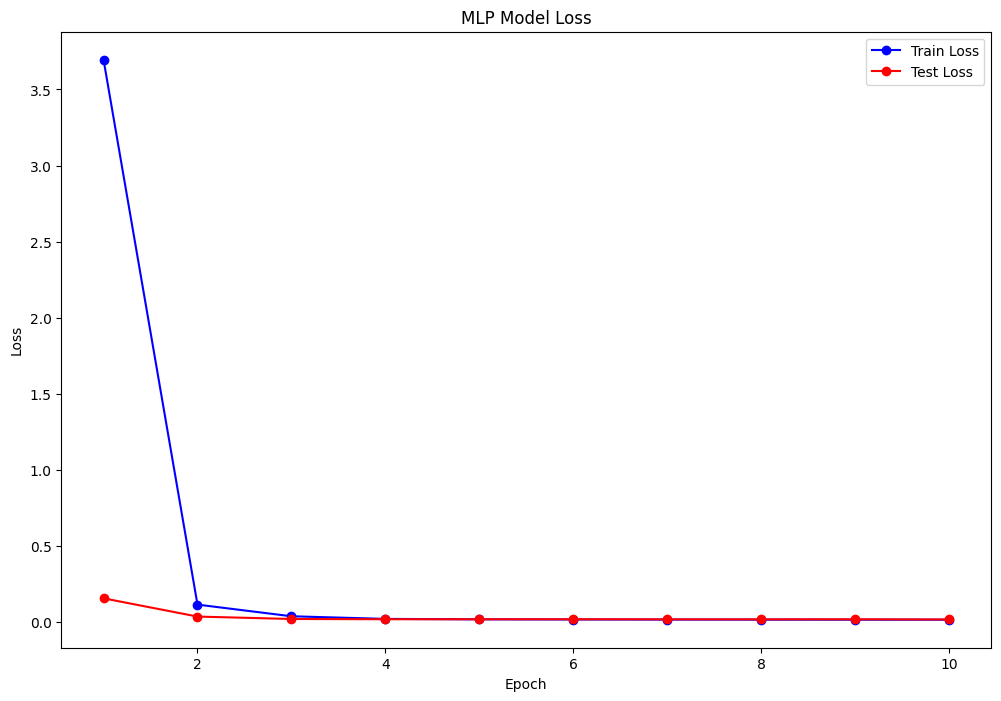

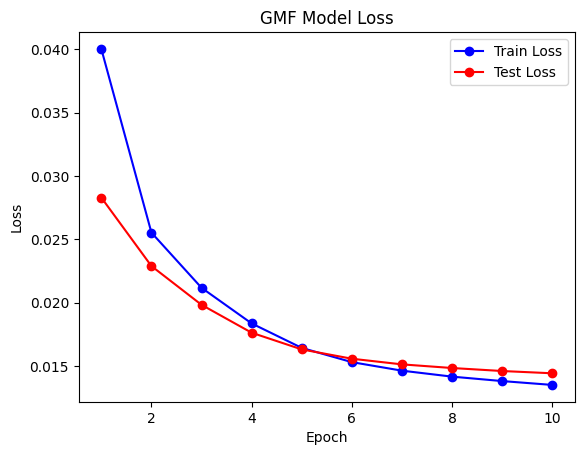

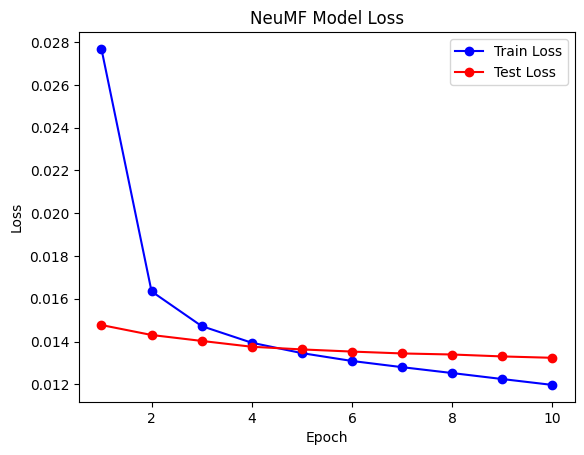

In [96]:
import matplotlib.pyplot as plt

# MLP model data
mlp_train_loss = [3.6950174334295, 0.11668900996973773, 0.040147326586463444, 0.022898902423949267, 0.019955833869365353, 
                  0.018866505908579186, 0.01828422652079384, 0.017863553787622624, 0.0176579500614437, 0.017454158246397105]
mlp_test_loss = [0.157952371776796, 0.03814665263147855, 0.022276981720272128, 0.0206319713626718, 0.020516480288159767, 
                 0.020635879038299828, 0.02011084193172132, 0.019992064000603074, 0.020253627192886033, 0.019198449493947483]

# GMF model data
gmf_train_loss = [0.04003728575764353, 0.025533486508182983, 0.021175410911702965, 0.018362480420187267, 0.016429371527416643, 
                  0.015305056382203475, 0.01463160192022472, 0.014160454717286095, 0.013809964230738773, 0.013505750678043297]
gmf_test_loss = [0.028299097051615502, 0.022891827709723422, 0.019831051891316644, 0.017628081791847532, 0.01631068073150627, 
                 0.015574246103732257, 0.015128253192493068, 0.014841098104719667, 0.014603769124104361, 0.014424409991700846]

# NeuMF model data
neumf_train_loss = [0.027678686989260452, 0.01634571377412012, 0.014723368335014456, 0.01394584908455086, 0.01346005102425137, 
                    0.013093187849867632, 0.012803735120885321, 0.01252872828114485, 0.012248591937687769, 0.011973678431735057]
neumf_test_loss = [0.014772928314505123, 0.014307665699783177, 0.01403033738548863, 0.013758254560114869, 0.013632847206995794, 
                   0.013532563343907766, 0.013445049989493694, 0.013395482611195579, 0.013305518026749452, 0.013241319170093422]

# Plotting the losses
plt.figure(figsize=(12, 8))

# MLP model loss
plt.plot(range(1, 11), mlp_train_loss, label="Train Loss", color='blue', marker='o')
plt.plot(range(1, 11), mlp_test_loss, label="Test Loss", color='red', marker='o')
plt.title("MLP Model Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

# GMF model loss
plt.plot(range(1, 11), gmf_train_loss, label="Train Loss", color='blue', marker='o')
plt.plot(range(1, 11), gmf_test_loss, label="Test Loss", color='red', marker='o')
plt.title("GMF Model Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

# NeuMF model loss

plt.plot(range(1, 11), neumf_train_loss, label="Train Loss", color='blue', marker='o')
plt.plot(range(1, 11), neumf_test_loss, label="Test Loss", color='red', marker='o')
plt.title("NeuMF Model Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()



The results for three models—MLP, GMF, and NeuMF—are presented over 10 epochs, showcasing their training, testing, and performance metrics. The MLP Model shows significant learning, with training loss decreasing from 3.6950 in the first epoch to 0.0175 in the tenth epoch. However, its test loss fluctuates slightly, starting at 0.1580 and ending at 0.0192. Its performance metrics are moderate, with a Test Mean Absolute Error (MAE) of 0.1104, Test Root Mean Squared Error (RMSE) of 0.1386, and an R² Score of 0.2205. The GMF Model, which uses Generalized Matrix Factorization, demonstrates more effective convergence, with training loss decreasing from 0.0400 to 0.0135 by the tenth epoch. Its test loss improves from 0.0283 to 0.0144. Performance metrics for GMF show a Test MAE of 0.0909, Test RMSE of 0.1201, and an R² Score of 0.4143, indicating better performance than the MLP Model. The NeuMF Model, based on Neural Matrix Factorization, outperforms the other two models. Its training loss decreases from 0.0277 to 0.0120, while test loss decreases slightly from 0.0148 to 0.0132. NeuMF’s performance metrics include the lowest Test MAE (0.0870), Test RMSE (0.1151), and the highest R² Score (0.4624), indicating the best overall performance. In summary, while the MLP Model shows significant learning, it exhibits moderate performance. The GMF Model demonstrates better performance with effective convergence and lower test loss than the MLP. However, the NeuMF Model achieves the best results, with the lowest test loss, MAE, RMSE, and the highest R² Score, making it the most effective in capturing user-item interactions among the three models.

In [99]:
"""
MLP Model
Epoch [1/10], Loss: 3.6950174334295
Test Loss [1/10]: 0.157952371776796
Epoch [2/10], Loss: 0.11668900996973773
Test Loss [2/10]: 0.03814665263147855
Epoch [3/10], Loss: 0.040147326586463444
Test Loss [3/10]: 0.022276981720272128
Epoch [4/10], Loss: 0.022898902423949267
Test Loss [4/10]: 0.0206319713626718
Epoch [5/10], Loss: 0.019955833869365353
Test Loss [5/10]: 0.020516480288159767
Epoch [6/10], Loss: 0.018866505908579186
Test Loss [6/10]: 0.020635879038299828
Epoch [7/10], Loss: 0.01828422652079384
Test Loss [7/10]: 0.02011084193172132
Epoch [8/10], Loss: 0.017863553787622624
Test Loss [8/10]: 0.019992064000603074
Epoch [9/10], Loss: 0.0176579500614437
Test Loss [9/10]: 0.020253627192886033
Epoch [10/10], Loss: 0.017454158246397105
Test Loss [10/10]: 0.019198449493947483
Test MAE: 0.1104
Test RMSE: 0.1386
R² Score: 0.2205

GMF Model
Epoch [1/10], Loss: 0.04003728575764353
Test Loss [1/10]: 0.028299097051615502
Epoch [2/10], Loss: 0.025533486508182983
Test Loss [2/10]: 0.022891827709723422
Epoch [3/10], Loss: 0.021175410911702965
Test Loss [3/10]: 0.019831051891316644
Epoch [4/10], Loss: 0.018362480420187267
Test Loss [4/10]: 0.017628081791847532
Epoch [5/10], Loss: 0.016429371527416643
Test Loss [5/10]: 0.01631068073150627
Epoch [6/10], Loss: 0.015305056382203475
Test Loss [6/10]: 0.015574246103732257
Epoch [7/10], Loss: 0.01463160192022472
Test Loss [7/10]: 0.015128253192493068
Epoch [8/10], Loss: 0.014160454717286095
Test Loss [8/10]: 0.014841098104719667
Epoch [9/10], Loss: 0.013809964230738773
Test Loss [9/10]: 0.014603769124104361
Epoch [10/10], Loss: 0.013505750678043297
Test Loss [10/10]: 0.014424409991700846
Test MAE: 0.0909
Test RMSE: 0.1201
R² Score: 0.4143

NeuMF Model
Epoch [1/10], Loss: 0.027678686989260452
Test Loss [1/10]: 0.014772928314505123
Epoch [2/10], Loss: 0.01634571377412012
Test Loss [2/10]: 0.014307665699783177
Epoch [3/10], Loss: 0.014723368335014456
Test Loss [3/10]: 0.01403033738548863
Epoch [4/10], Loss: 0.01394584908455086
Test Loss [4/10]: 0.013758254560114869
Epoch [5/10], Loss: 0.01346005102425137
Test Loss [5/10]: 0.013632847206995794
Epoch [6/10], Loss: 0.013093187849867632
Test Loss [6/10]: 0.013532563343907766
Epoch [7/10], Loss: 0.012803735120885321
Test Loss [7/10]: 0.013445049989493694
Epoch [8/10], Loss: 0.01252872828114485
Test Loss [8/10]: 0.013395482611195579
Epoch [9/10], Loss: 0.012248591937687769
Test Loss [9/10]: 0.013305518026749452
Epoch [10/10], Loss: 0.011973678431735057
Test Loss [10/10]: 0.013241319170093422
Test MAE: 0.0870
Test RMSE: 0.1151
R² Score: 0.4624
"""

'\nMLP Model\nEpoch [1/10], Loss: 3.6950174334295\nTest Loss [1/10]: 0.157952371776796\nEpoch [2/10], Loss: 0.11668900996973773\nTest Loss [2/10]: 0.03814665263147855\nEpoch [3/10], Loss: 0.040147326586463444\nTest Loss [3/10]: 0.022276981720272128\nEpoch [4/10], Loss: 0.022898902423949267\nTest Loss [4/10]: 0.0206319713626718\nEpoch [5/10], Loss: 0.019955833869365353\nTest Loss [5/10]: 0.020516480288159767\nEpoch [6/10], Loss: 0.018866505908579186\nTest Loss [6/10]: 0.020635879038299828\nEpoch [7/10], Loss: 0.01828422652079384\nTest Loss [7/10]: 0.02011084193172132\nEpoch [8/10], Loss: 0.017863553787622624\nTest Loss [8/10]: 0.019992064000603074\nEpoch [9/10], Loss: 0.0176579500614437\nTest Loss [9/10]: 0.020253627192886033\nEpoch [10/10], Loss: 0.017454158246397105\nTest Loss [10/10]: 0.019198449493947483\nTest MAE: 0.1104\nTest RMSE: 0.1386\nR² Score: 0.2205\n\nGMF Model\nEpoch [1/10], Loss: 0.04003728575764353\nTest Loss [1/10]: 0.028299097051615502\nEpoch [2/10], Loss: 0.025533486